<a href="https://colab.research.google.com/github/char704/Region-of-Interest/blob/main/roi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

manual_test

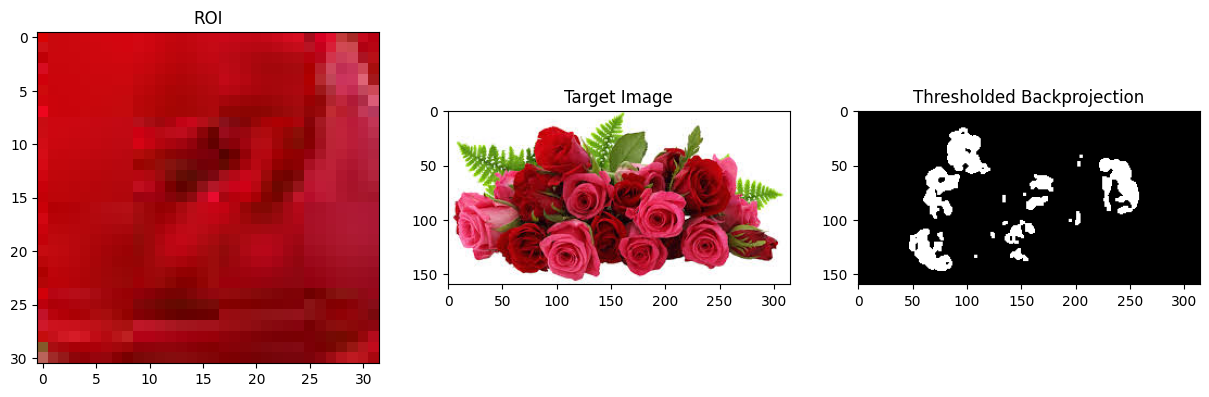

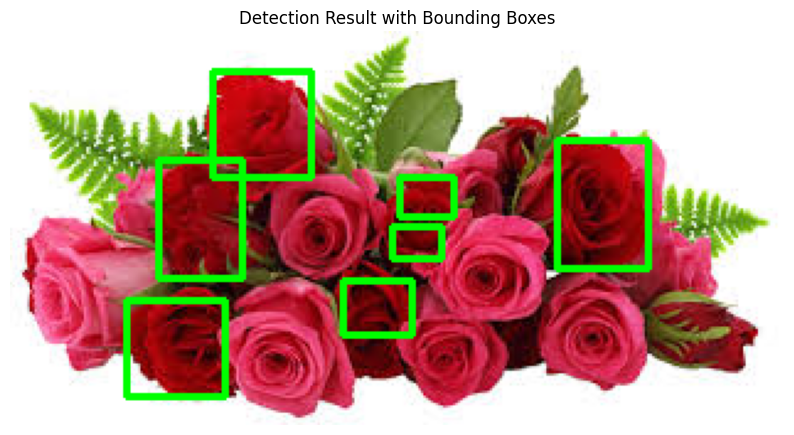

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the images
roi = cv2.imread('/content/roi.png')
target = cv2.imread('/content/roses.png')

# Verify images loaded
if roi is None or target is None:
    raise ValueError("Failed to load one or both images. Check file paths.")

# Convert to HSV color space
hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
hsv_target = cv2.cvtColor(target, cv2.COLOR_BGR2HSV)

# **Step 1: Manually Calculate 2D Histogram**
# Initialize histogram: 180 bins for H, 64 bins for S
hist = np.zeros((180, 64), dtype=np.float32)

# Extract H and S channels and flatten
hsv_roi_h = hsv_roi[:, :, 0].ravel()  # Hue values (0-179)
hsv_roi_s = hsv_roi[:, :, 1].ravel()  # Saturation values (0-255)

# Compute bin indices for S (256 / 64 = 4 units per bin)
bin_s_indices = (hsv_roi_s // 4).astype(int)

# Accumulate counts using advanced indexing
indices = (hsv_roi_h, bin_s_indices)
np.add.at(hist, indices, 1)

# **Step 2: Manually Normalize Histogram**
min_val = hist.min()
max_val = hist.max()
if max_val > min_val:
    hist_normalized = 255 * (hist - min_val) / (max_val - min_val)
else:
    hist_normalized = np.zeros_like(hist)  # Handle case where histogram is flat

# **Step 3: Ratio Computation (Skipped)**
# Note: Assuming no background histogram is provided, we skip ratio computation.
# If needed, you'd compute: hist_normalized = roi_hist / (background_hist + eps)

# **Step 4: Manually Perform Backprojection**
# Get H and S channels from target image
bin_h = hsv_target[:, :, 0]  # Shape: (height, width)
bin_s = (hsv_target[:, :, 1] // 4).astype(int)  # Shape: (height, width)

# Create backprojection by indexing into normalized histogram
backproj = hist_normalized[bin_h, bin_s]  # Shape: (height, width), dtype: float32

# Convert backproj to 8-bit unsigned integer before applying threshold
backproj = backproj.astype(np.uint8)

# Apply Gaussian blur
backproj = cv2.GaussianBlur(backproj, (7, 7), 0)

# Threshold with Otsu's method
_, thresh = cv2.threshold(backproj, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Morphological operations
kernel = np.ones((3, 3), np.uint8)
thresh = cv2.erode(thresh, kernel, iterations=1)
thresh = cv2.dilate(thresh, kernel, iterations=1)

# Find contours and draw bounding boxes
contours, _ = cv2.findContours(thresh.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
result = cv2.cvtColor(target, cv2.COLOR_BGR2RGB).copy()
for contour in contours:
    if cv2.contourArea(contour) > 100:  # Filter small contours
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(result, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Visualization
plt.figure(figsize=(15, 5))
plt.subplot(131), plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)), plt.title('ROI')
plt.subplot(132), plt.imshow(cv2.cvtColor(target, cv2.COLOR_BGR2RGB)), plt.title('Target Image')
plt.subplot(133), plt.imshow(thresh, cmap='gray'), plt.title('Thresholded Backprojection')
plt.show()

plt.figure(figsize=(10, 8))
plt.imshow(result)
plt.title('Detection Result with Bounding Boxes')
plt.axis('off')
plt.show()

opencv_test

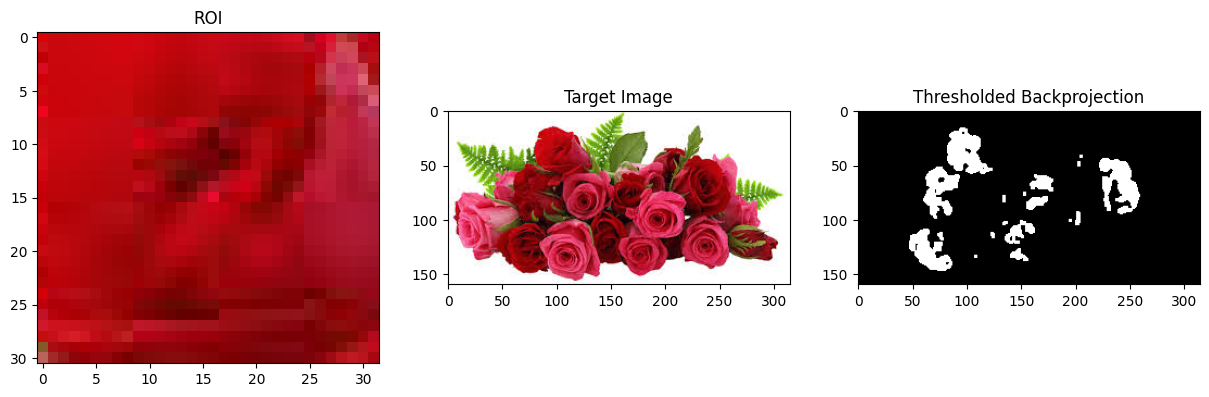

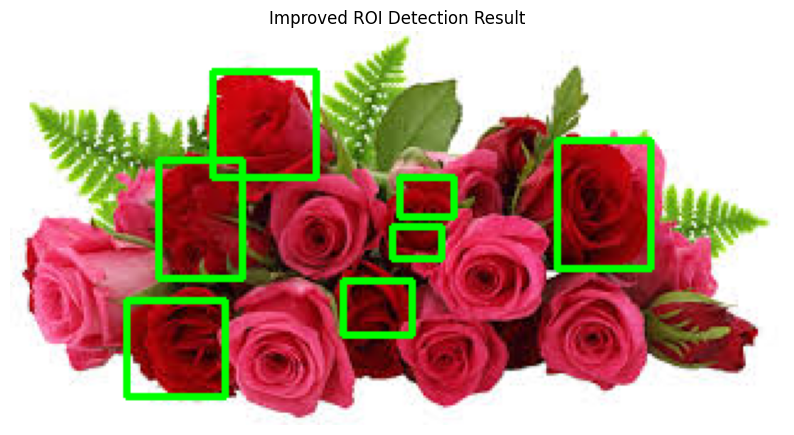

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read the images
roi = cv2.imread('/content/roi.png')
target = cv2.imread('/content/roses.png')

# Check if images loaded successfully
if roi is None or target is None:
    raise ValueError("One or both images failed to load. Check file paths.")

# Convert both images to HSV color space
hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
hsv_target = cv2.cvtColor(target, cv2.COLOR_BGR2HSV)

# Calculate histogram for ROI (reduced Saturation bins to 64 for robustness)
roi_hist = cv2.calcHist([hsv_roi], [0, 1], None, [180, 64], [0, 180, 0, 256])

# Normalize histogram to [0, 255]
cv2.normalize(roi_hist, roi_hist, 0, 255, cv2.NORM_MINMAX)

# Define ranges for backprojection
hsv_ranges = [0, 180, 0, 256]
channels = [0, 1]  # Using Hue and Saturation channels

# Perform backprojection
backproj = cv2.calcBackProject([hsv_target], channels, roi_hist, hsv_ranges, scale=1)

# Apply Gaussian blur for smoothing (experiment with kernel size)
backproj = cv2.GaussianBlur(backproj, (7, 7), 0)  # Changed from filter2D for better noise reduction

# Threshold using Otsu's method for adaptability
_, thresh = cv2.threshold(backproj, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Apply morphological operations to refine the mask
kernel = np.ones((3, 3), np.uint8)
thresh = cv2.erode(thresh, kernel, iterations=1)  # Remove small noise
thresh = cv2.dilate(thresh, kernel, iterations=1)  # Fill gaps in detected regions

# Find contours and draw bounding boxes for visualization
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
result = cv2.cvtColor(target, cv2.COLOR_BGR2RGB).copy()
for contour in contours:
    # Filter small contours (optional, adjust area threshold as needed)
    if cv2.contourArea(contour) > 100:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(result, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Green boxes

# Display intermediate results
plt.figure(figsize=(15, 5))
plt.subplot(131), plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)), plt.title('ROI')
plt.subplot(132), plt.imshow(cv2.cvtColor(target, cv2.COLOR_BGR2RGB)), plt.title('Target Image')
plt.subplot(133), plt.imshow(thresh, cmap='gray'), plt.title('Thresholded Backprojection')
plt.show()

# Display final detection result with bounding boxes
plt.figure(figsize=(10, 8))
plt.imshow(result)
plt.title('Improved ROI Detection Result')
plt.axis('off')
plt.show()